# IHFA - Índice de Hedge Funds ANBIMA

O IHFA (Índice de Hedge Funds ANBIMA) é uma referência para a indústria de hedge funds. No Brasil, esses produtos se assemelham aos fundos multimercado de gestão ativa, com aplicações em diversos segmentos do mercado e várias estratégias de investimento.

O índice conta com os fundos mais representativos do segmento em sua carteira e pPara garantir a representatividade, o IHFA é ajustado trimestralmente, seguindo os seguintes critérios qualitativos e quantitativos:

- Seleção apenas dos fundos multimercados que estejam enquadrados nessa classe há mais de um ano.
- Exclusão dos fundos fechados, dos exclusivos e daqueles que não cobram taxa de performance.
- Exclusão dos fundos com número médio de cotistas inferior a dez no trimestre anterior à data de rebalanceamento.
- Exclusão dos fundos que não divulgam o valor das cotas atualizadas diariamente.

O objetivo desta análise é verificar os retornos, volitilidade e outras estatísticas dos fundos presente no índice.

Input files:
- IHF_TEORICO.csv: https://www.anbima.com.br/pt_br/informar/consulta-ihfa.htm
- data.xlsx: preencher manualmente

Fontes:
- Histórico IHFA: https://inva.capital/brasil/wp-content/uploads/sites/4/2020/07/2020-07.pdf
- Histórico CDI e IPCA: https://www.debit.com.br/tabelas/tabela-completa.php?indice=cdi
- Histórico IBOV, IFIX e Dólar: https://br.investing.com/

Output files:
- Relação Retorno x Volatilidade: retorno-vol.png
- Indicadores: retorno_tabela.png
- Ano de origem dos fundos: fundos_por_ano.png
- Quantidade de fundos por ano de origem: fundos_mais_antigos.png

TODO:
- Obter dados do IHFA desde mai/2008 (origem do índice). Até o momento só possuo desde de nov/2012

In [1]:
import pandas as pd
from pandas.plotting import table 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import six
from requests import Session
import json
from glob import glob
import datetime
%matplotlib inline

# Extrair fundos da carteira teórica do índice

In [131]:
ihf = pd.read_csv('input/IHF_TEORICO.csv',encoding='latin1', sep=';', skiprows=3)

In [132]:
ihf.drop(['Data Início','Data Final'], axis='columns', inplace=True)

Preparar valores numéricos e CNPJ

In [133]:
ihf.iloc[:,2:] = ihf.iloc[:,2:].apply(lambda x: x.str.replace('.','').str.replace(',','.'))
ihf[ihf.columns[2:]] = ihf.iloc[:,2:].astype(float)

In [134]:
ihf.iloc[:,1:2] = ihf.iloc[:,1:2].apply(lambda x: x.str.replace('.','').str.replace('/','').str.replace('-',''))

Ordenar pelo fundo com maior participação no índice

In [135]:
ihf.sort_values(by=['Participação Relativa (%)'], ascending=False, inplace=True)

# Obter perfomance histórica de cada fundo

In [136]:
def featch_url(cnpj):
    url = 'https://assets-comparacaodefundos.s3-sa-east-1.amazonaws.com/cvm/' + str(cnpj)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:82.0) Gecko/20100101 Firefox/82.0',
        'Accepts': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    }
    
    session = Session()
    session.headers.update(headers)
    response = session.get(url)
    return json.loads(response.text)

In [147]:
'''
Formato do JSON:
    "c": rendimento diário da cota 
    "d": data (YYYYMMDD)
    "p": patrimônio líquido
    "q": total de cotistas
'''
def convert_json_to_df(json, name):
    df = pd.DataFrame(json)  
    df['d'] = pd.to_datetime(df['d'], format='%Y%m%d')
    df.set_index('d', inplace=True)
    
    #Normaliza valores e subtrai pelo primeiro valor
    df[name] = (df.c / df.c.iloc[0]) - 1
    
    #Filtra por mês com o valor do último dia do mês atual / valor do último dia do mês passado (1+Actual)/(1+Past)-1
    df = df.resample('M').last()
    df[name] = (1 + df[name]) / (1 + df[name].shift(1)) - 1
    
    df.fillna(0, inplace=True)
    df.drop(columns=['c','p','q'], inplace=True)
    return df

Cria diretório com performance de cada fundo do índice

In [148]:
for i in range(ihf.shape[0]):    
    df = convert_json_to_df(featch_url(ihf['CNPJ'][i]), ihf['Fundo'][i])
    df.to_excel('output/'+ihf['Fundo'][i].split()[0]+'_'+ihf['CNPJ'][i]+'.xlsx')        

# Calcular estatísticas

In [149]:
def total_return(returns):
    return ((returns + 1).cumprod() - 1).iloc[-1]

def cagr(returns):
    return (1+total_return(returns)) ** (1/(len(returns)/12)) - 1

def vol(returns, n=12):
    return returns.std() * np.sqrt(n)

def cdi_perc(returns, rf):
    return total_return(returns)/total_return(rf)

def sharpe_ratio(returns, rf):
    return (total_return(returns) - total_return(rf)) / vol(returns)

def beta(returns, market):
    return np.cov(returns, market)[0][1] / np.var(market, ddof=1)

def treynor_ratio(returns, market, rf):
    return (total_return(returns) - total_return(rf)) / beta(returns, market)

def alpha_jensen(returns, market, rf):
    return (total_return(returns) - total_return(rf)) - beta(returns, market)*(total_return(market)-total_return(rf))

def corr(returns, market):
    return np.corrcoef(returns,market)[0][1]

def months_above_benchmark(returns, benchmark):
    return sum(returns>benchmark)/len(returns) 

def max_return(returns):
    return max(returns)

def min_return(returns):
    return min(returns)

def prices(returns, base):
    s = [base]
    for i in range(len(returns)):
        s.append(base * (1 + returns.tolist()[i]))
    return np.array(s)

def drawdown(returns, tau):
    values = prices(returns, 100)
    pos = len(values) - 1
    pre = pos - tau
    drawdown = float('+inf')
    while pre >= 0:
        dd_i = (values[pos] / values[pre]) - 1
        if dd_i < drawdown:
            drawdown = dd_i
        pos, pre = pos - 1, pre - 1
    return abs(drawdown)

def max_drawdown(returns):
    max_drawdown = float('-inf')
    for i in range(0, len(returns)):
        drawdown_i = drawdown(returns, i)
        if drawdown_i > max_drawdown:
            max_drawdown = drawdown_i
    return abs(max_drawdown)

def stress_test(returns):
    return returns.mean()-(3*vol(returns))

# Comparar dados: Retorno vs Volatilidade

Filtrar somente fundos que foram criados antes desta data e existem até hoje

In [150]:
start_date = '2012-11-01'

Obter índices de benchmark e carteiras 

In [151]:
data = pd.read_excel('input/data.xlsx')

In [152]:
data = data[data.iloc[:,0] >= start_date]

In [153]:
end_date = data.dropna().tail(1).iloc[-1,0]

In [154]:
benchmarks = data.drop(['IPCA','IHFA'], axis=1).dropna().set_index(data.columns[0])
ihfa = data.drop(['CDI','IPCA','Dólar','Ibovespa','IFIX'], axis=1).dropna().set_index(data.columns[0])

In [155]:
benchmark_return_vol = pd.DataFrame() 
for i in range(benchmarks.shape[1]): 
    benchmark_return_vol = benchmark_return_vol.append(dict(zip(['Fundo','Retorno','VOL'],[benchmarks.columns[i], total_return(benchmarks.iloc[:,i]), vol(benchmarks.iloc[:,i])])), ignore_index=True)                                    

In [156]:
ihfa_return_vol = pd.DataFrame() 
for i in range(ihfa.shape[1]): 
    ihfa_return_vol = ihfa_return_vol.append(dict(zip(['Fundo','Retorno','VOL'],[ihfa.columns[i], total_return(ihfa.iloc[:,i]), vol(ihfa.iloc[:,i])])), ignore_index=True)                                    

Obter dados dos fundos

In [157]:
pages = glob('output/*.xlsx')

In [196]:
'''
page: arquivo excel com informação do fundo
start_date: data para filtrar fundo que foi criado antes desta data e existe até hoje
all_funds: se 'True' é considerado qualquer fundo, independente da data de criação.
'''
def get_data_by_start_date(page, start_date, all_funds=False):
    df = pd.read_excel(page)
    fund_creation = df.d[[0]].dt.strftime("%Y-%m-%d")
    
    # filtro para somar retorno a partir desta data
    df = df[df.d >= start_date]

    if not all_funds:
        if fund_creation[0] < start_date:
            return dict(zip(['Fundo','Retorno','VOL'],[df.columns[1], total_return(df.iloc[:,1]), vol(df.iloc[:,1])]))
    else:
        return dict(zip(['Fundo','Retorno','VOL'],[df.columns[1], total_return(df.iloc[:,1]), vol(df.iloc[:,1])]))

In [202]:
fund_return_vol = pd.DataFrame() 
dfs = [ get_data_by_start_date(page, start_date, True) for page in pages ]
dfs = list(filter(None, dfs))
fund_return_vol = fund_return_vol.append(dfs, ignore_index=True)

Exibir resultados

In [203]:
# ler somente 4 primeiras palavras do nome do fundo para melhor exibir no gráfico
df_temp = fund_return_vol.copy()
df_temp['Fundo'] = fund_return_vol['Fundo'].apply(lambda x: ' '.join(x.split()[0:3]))

In [204]:
df = pd.concat([df_temp.assign(dataset='Fundos'),
                benchmark_return_vol.assign(dataset='Índice'), 
                ihfa_return_vol.assign(dataset='IHFA')], sort=True)

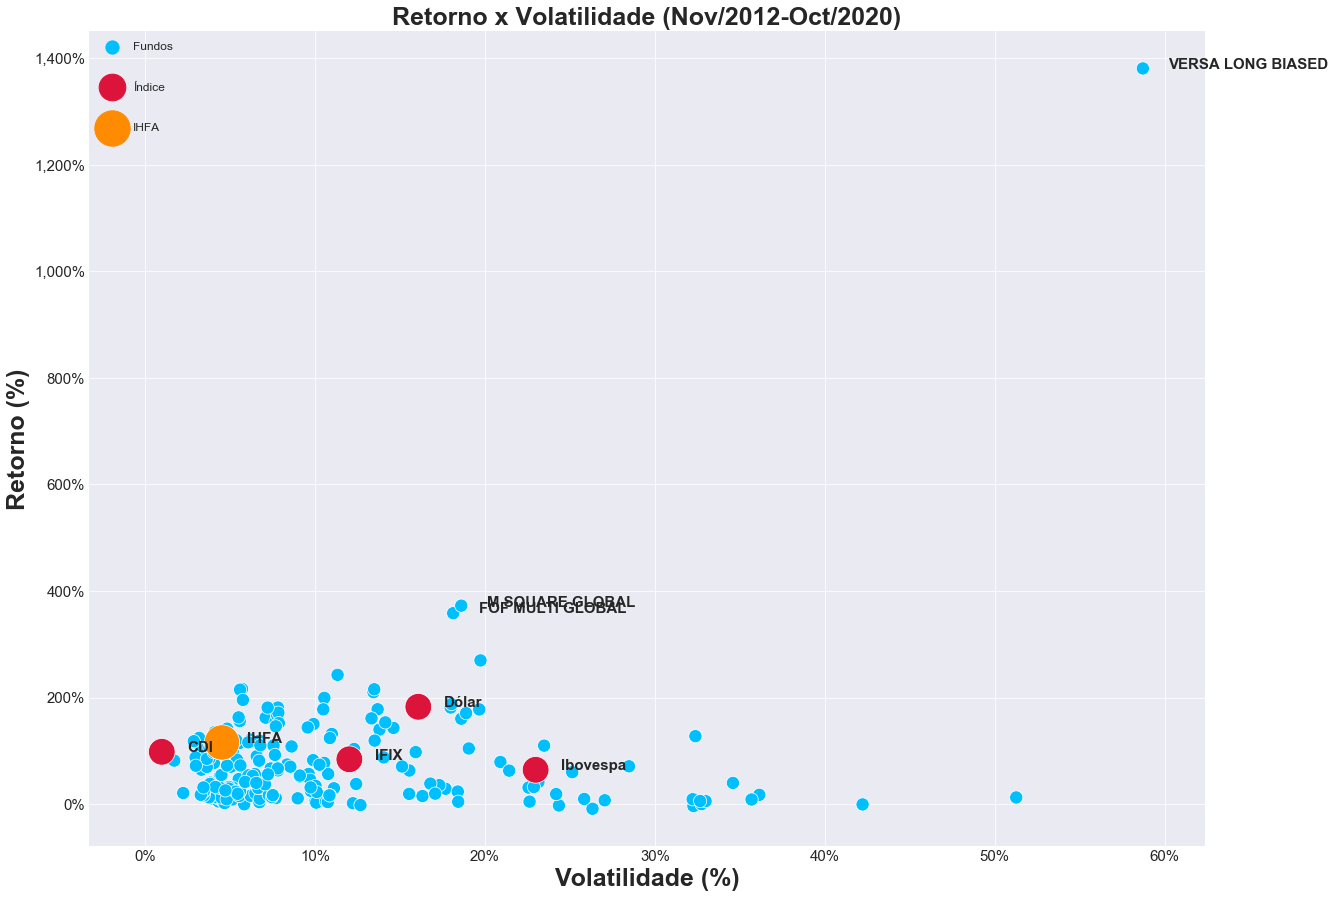

In [205]:
color = ['deepskyblue','crimson','darkorange']

fig, ax = plt.subplots(figsize=(20, 15))
s = sns.scatterplot(data=df, x='VOL', y='Retorno', hue='dataset', size='dataset',
                     sizes=(1250, 175), palette=color, ax=ax)

s_datee = datetime.datetime.strptime(start_date, "%Y-%m-%d")
period = str(s_datee.strftime("%b")) + '/' + str(s_datee.year) + \
         '-' + str(end_date.strftime("%b")) + '/' + str(end_date.year)

plt.title('Retorno x Volatilidade' + ' ('+period+')', fontsize=25, fontweight='bold')
plt.xlabel('Volatilidade (%)', fontsize=25, fontweight='bold')
plt.ylabel('Retorno (%)', fontsize=25, fontweight='bold')

vals = s.get_xticks()
s.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15)
vals = s.get_yticks()
s.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], labelspacing=2.5, fontsize=12)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)    

    for i, point in a.iterrows():
        ax.text(point['x']+.015, point['y'], str(point['val']), fontsize=15, fontweight='bold')

x = df[df['dataset'] == 'Fundos'].sort_values(by='Retorno', ascending=False).head(3).VOL
y = df[df['dataset'] == 'Fundos'].sort_values(by='Retorno', ascending=False).head(3).Retorno
val = df[df['dataset'] == 'Fundos'].sort_values(by='Retorno', ascending=False).head(3).Fundo
label_point(x, y, val, plt.gca()) 
        
x = df[df['dataset'] == 'Índice'].VOL
y = df[df['dataset'] == 'Índice'].Retorno
val = df[df['dataset'] == 'Índice'].Fundo            
label_point(x, y, val, plt.gca()) 

x = df[df['dataset'] == 'IHFA'].VOL
y = df[df['dataset'] == 'IHFA'].Retorno
val = df[df['dataset'] == 'IHFA'].Fundo            
label_point(x, y, val, plt.gca()) 

plt.style.use('seaborn-darkgrid')
plt.savefig('retorno-vol.png',dpi=300)

In [206]:
fund_return_vol.sort_values(by='Retorno', ascending=False)

,Fundo,Retorno,VOL
225,VERSA LONG BIASED FUNDO DE INVESTIMENTO MULTIM...,13.803136,0.587210
145,M SQUARE GLOBAL EQUITY MANAGERS INSTITUCIONAL ...,3.725660,0.186064
60,FOF MULTI GLOBAL EQUITIES MULTIMERCADO INVESTI...,3.584164,0.181311
230,VISTA MULTIESTRATÉGIA FUNDO DE INVESTIMENTO EM...,2.698474,0.197371
71,GIANT ZARATHUSTRA FUNDO DE INVESTIMENTO EM COT...,2.427184,0.113257
...,...,...,...
18,ALPHA KEY LONG BIASED II FUNDO DE INVESTIMENTO...,-0.002778,0.422245
118,KAPITALO APOLLINHO III FUNDO DE INVESTIMENTO E...,-0.015060,0.126711
100,ITAÚ LONG BIAS MULTIMERCADO FUNDO DE INVESTIME...,-0.022986,0.243545
22,APEX LONG BIASED ADVISORY FUNDO DE INVESTIMENT...,-0.032833,0.322711


## Indicadores da performance do índice

In [164]:
CDI = benchmarks.loc[:,'CDI']
IBOV = benchmarks.loc[:,'Ibovespa']
IHFA = ihfa.iloc[:,0]

In [165]:
index = ['Retorno Acumulado','CAGR','Volatilidade Anualizada','% CDI','Índice Sharpe','Índice Treynor','Alpha de Jensen','Meses acima CDI',
        'Maior Retorno Mensal','Menor Retorno Mensal','Maior Queda','Stress Test']
columns = ['IHFA', 'IBOV', 'CDI']
data = {columns[0]: [str(round(total_return(IHFA)*100,2))+'%',
                     str(round(cagr(IHFA)*100,2))+'%',
                     str(round(vol(IHFA)*100,2))+'%',
                     str(round(cdi_perc(IHFA, CDI)*100,2))+'%',
                     round(sharpe_ratio(IHFA, CDI),2),
                     round(treynor_ratio(IHFA, IBOV, CDI),2),
                     round(alpha_jensen(IHFA, IBOV, CDI),2),
                     str(round(months_above_benchmark(IHFA, CDI)*100,2))+'%',
                     str(round(max_return(IHFA)*100,2))+'%',
                     str(round(min_return(IHFA)*100,2))+'%',
                     str(-round(max_drawdown(IHFA)*100,2))+'%',
                     str(round(stress_test(IHFA)*100,2))+'%'],
        columns[1]: [str(round(total_return(IBOV)*100,2))+'%',
                     str(round(cagr(IBOV)*100,2))+'%',
                     str(round(vol(IBOV)*100,2))+'%',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     str(round(max_return(IBOV)*100,2))+'%',
                     str(round(min_return(IBOV)*100,2))+'%',
                     str(-round(max_drawdown(IBOV)*100,2))+'%',
                     str(round(stress_test(IBOV)*100,2))+'%'],
        columns[2]: [str(round(total_return(CDI)*100,2))+'%',
                     str(round(cagr(CDI)*100,2))+'%',
                     str(round(vol(CDI)*100,2))+'%',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-']}
df_sts = pd.DataFrame(data=data, index=index)

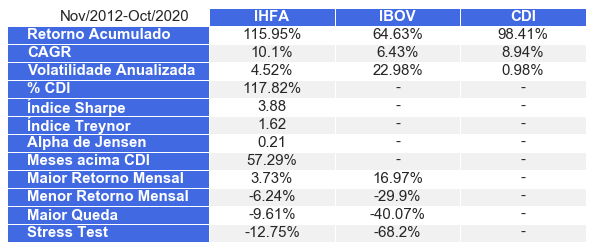

In [166]:
fig, ax = plt.subplots(figsize=(5, 1))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

header_color = 'royalblue'
row_colors = ['#f1f1f2', 'w']

tab = table(ax, df_sts, loc='upper left', cellLoc='center', colWidths=[0.30]*len(df_sts.columns))

# index name
w, h = tab[0,1].get_width(), tab[0,1].get_height()
tab.add_cell(0, -1, w, h, text=period)

#properties
tab.auto_set_font_size(False)
tab.set_fontsize(15)
tab.scale(1.5, 1.5)

#coloring
for k, cell in six.iteritems(tab._cells):
    cell.set_edgecolor('w')
        
    if k[0] == 0 and k[1] == -1:
        pass   
    elif k[0] == 0 or k[1] < 0:
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors)])

plt.savefig('retorno_tabela.png',dpi=300, bbox_inches = 'tight')

## Listar fundos mais antigos do IHFA por ano

Quantidade de fundos por ano de origem

In [183]:
def get_data_by_year(page):
    df = pd.read_excel(page)
    df['d'] = df['d'].dt.strftime('%Y')
    return df.drop_duplicates(subset = ['d']).set_index(df.columns[0]) 

In [187]:
dfs = [ get_data_by_year(page) for page in pages ]
funds_by_year = pd.concat(dfs, axis=1, sort=True)

In [192]:
df_temp = pd.DataFrame(data={'Fundos': funds_by_year.apply(lambda x: x.notnull().sum(), axis='columns')})

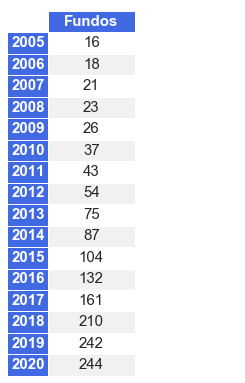

In [193]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

header_color = 'royalblue'
row_colors = ['#f1f1f2', 'w']

tab = table(ax, df_temp, loc='upper left', cellLoc='center', colWidths=[0.30]*len(df_temp.columns))

#properties
tab.auto_set_font_size(False)
tab.set_fontsize(15)
tab.scale(1.5, 1.5)

#coloring
for k, cell in six.iteritems(tab._cells):
    cell.set_edgecolor('w')

    if k[0] == 0 or k[1] < 0:
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors)])

plt.tight_layout()
plt.savefig('fundos_por_ano.png', bbox_inches = 'tight')

Quais são os mais antigos?

In [194]:
funds_by_year.loc[funds_by_year.index[1]].dropna().index
data = {funds_by_year.index[1]: funds_by_year.loc[funds_by_year.index[1]].dropna().index}
oldest_funds = pd.DataFrame(data=data)

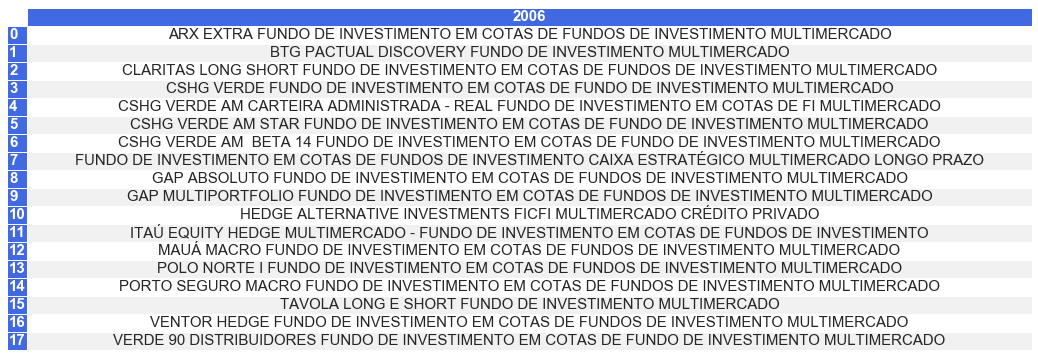

In [195]:
fig, ax = plt.subplots(figsize=(3, 1))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

header_color = 'royalblue'
row_colors = ['#f1f1f2', 'w']

tab = table(ax, oldest_funds, loc='upper left', cellLoc='center', colWidths=[4.0]*len(oldest_funds.columns))

#properties
tab.auto_set_font_size(False)
tab.set_fontsize(15)
tab.scale(1.5, 1.5)

#coloring
for k, cell in six.iteritems(tab._cells):
    cell.set_edgecolor('w')

    if k[0] == 0 or k[1] < 0:
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors)])

#plt.tight_layout()
plt.savefig('fundos_mais_antigos.png',dpi=300, bbox_inches = 'tight')